<a href="https://colab.research.google.com/github/scott2434/hello-world/blob/master/Roboflow_TFLite_Object_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction


In this notebook, we use [TensorFlow Lite](https://www.tensorflow.org/lite/models/object_detection/overview) to prepare a custom model on your own dataset for low-end (e.g. mobile) devices. It takes three steps:

1.   Import our dataset from Roboflow
2.   Train a TensorFlow2 Object Detection Model
3.   Convert the model to TensorFlow Lite


**If you only want the finished model**_, there are only three steps:_
1. _Change the two dataset URLs under "Prepare Data"_
2. _Update these TFRecord names under "Prepare tfrecord files"_
3. _At the very bottom, choose where to save it in your google drive and authorize_

_Now run the entire notebook and you'll have your TFLite model at the end!_


### **Reach out for support**

If you run into any hurdles on your own data set or just want to share some cool results in your own domain, [reach out!](https://roboflow.ai)

#### ![Roboflow Workmark](https://i.imgur.com/WHFqYSJ.png)

# 1. Import

## Prepare Data


To train a TensorFlow2 Object Detection Model, we need TFRecord and label_map files. Roboflow creates these files for us!

Because we need one TFRecord file for our training data, and one TFRecord file for our test data, we'll split the dataset into "train" and "test".

To create a dataset in Roboflow and generate TFRecords, follow [this step-by-step guide](https://blog.roboflow.ai/getting-started-with-roboflow/). On export, select "Tensorflow TFRecord" for the first link and "COCO JSON" as the second link below.

![](https://i.imgur.com/ZwMdcbY.png)

In [1]:
#Main Training and Test Set

#Downloading data from Roboflow
#UPDATE THIS LINK - get our data from Roboflow
%mkdir /content/train/
%cd /content/train/
!curl -L "https://app.roboflow.com/ds/u5ASSB6x4O?key=tehaU6TQfv" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

/content/train
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   891  100   891    0     0   1019      0 --:--:-- --:--:-- --:--:--  1018
100  563k  100  563k    0     0   258k      0  0:00:02  0:00:02 --:--:--  512k
Archive:  roboflow.zip
 extracting: README.dataset.txt      
 extracting: README.roboflow.txt     
   creating: test/
 extracting: test/empty.tfrecord     
 extracting: test/empty_label_map.pbtxt  
   creating: train/
 extracting: train/empty.tfrecord    
 extracting: train/empty_label_map.pbtxt  
   creating: valid/
 extracting: valid/empty.tfrecord    
 extracting: valid/empty_label_map.pbtxt  


In [2]:
#Inference Test Set - Optional!

#downloading test images from Roboflow
#export dataset above with format COCO JSON
#or import your test images via other means. 
%mkdir /content/test/
%cd /content/test/

#UPDATE THIS LINK - get our data from Roboflow
#Or remove line entirely if you don't want to test inference
!curl -L "https://app.roboflow.com/ds/GY4GpSET4A?key=XtvF7yVZNQ" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

/content/test
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   887  100   887    0     0    878      0  0:00:01  0:00:01 --:--:--   878
100  597k  100  597k    0     0   431k      0  0:00:01  0:00:01 --:--:--  145M
Archive:  roboflow.zip
 extracting: README.dataset.txt      
 extracting: README.roboflow.txt     
   creating: test/
 extracting: test/TLC00004_Moment_jpg.rf.2f7853d601225c83aed803a439d20141.jpg  
 extracting: test/TLC_9-05_Moment_jpg.rf.2cd34157c8b2568651ecb2f6f4d1ec1a.jpg  
 extracting: test/_annotations.coco.json  
   creating: train/
 extracting: train/TLC00002_Moment_jpg.rf.b0b503b4cb046642afeca189af254ea3.jpg  
 extracting: train/TLC00003_Moment_jpg.rf.9cd119e3bc6b12e9523eef85fead0fed.jpg  
 extracting: train/TLC00005_Moment_jpg.rf.30a0af017e23343c7d2682a468b32136.jpg  
 extracting: train/TLC00008_Moment_jpg.rf.d8ff29271fb3436361fa86f3c4d8c516.jpg  
 extr

# 2. Train

_Note that this section is based on the [MobileNetSSDv2 Notebook](https://colab.research.google.com/drive/1wTMIrJhYsQdq_u7ROOkf0Lu_fsX5Mu8a). This is because TensorFlow Lite is independent of the model used, so we're picking a simple and lightweight solution._

## **Training MobileNetSSD Object Detection on a Custom Dataset**

💡 Recommendation: [Open this blog post](https://blog.roboflow.ai/training-a-tensorflow-object-detection-model-with-a-custom-dataset/) to continue.

### **Overview**

This notebook walks through how to train a MobileNet object detection model using the TensorFlow 1.5 Object Detection API.

In this specific example, we'll training an object detection model to recognize cells types: white blood cells, red blood cells and platelets. **To adapt this example to train on your own dataset, you only need to change two lines of code in this notebook.**

Everything in this notebook is also hosted on this [GitHub repo](https://github.com/josephofiowa/tensorflow-object-detection).

![Blood Cell Example](https://i.imgur.com/QwyX2aD.png)

**Credit to [DLology](https://www.dlology.com/blog/how-to-train-an-object-detection-model-easy-for-free/) and [Tony607](https://github.com/Tony607)**, whom wrote the first notebook on which much of this is example is based. 

### **Our Model**

We'll be training a MobileNetSSDv2 (single shot detector). This specific model is a one-short learner, meaning each image only passes through the network once to make a prediction, which allows the architecture to be very performant for mobile hardware.

The model arechitecture is one of many available via TensorFlow's [model zoo](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md#coco-trained-models).

As a note, this notebook presumes TensorFlow 1.5 as TensorFlow 2.0 has yet to fully support the object detection API.

### **Training**

Google Colab provides free GPU resources. Click "Runtime" → "Change runtime type" → Hardware Accelerator dropdown to "GPU."

Colab does have memory limitations, and notebooks must be open in your browser to run. Sessions automatically clear themselves after 12 hours.

### **Inference**

We'll run inference directly in this notebook, and on three test images contained in the "test" folder from our GitHub repo. 

When adapting to your own dataset, you'll need to add test images to the `test` folder located at `tensorflow-object-detection/test`.

### **About**

[Roboflow](https://roboflow.ai) makes managing, preprocessing, augmenting, and versioning datasets for computer vision seamless.

Developers reduce 50% of their boilerplate code when using Roboflow's workflow, automate labelling quality assurance, save training time, and increase model reproducibility.

#### ![Roboflow Workmark](https://i.imgur.com/WHFqYSJ.png)







## Configs and Hyperparameters

Support a variety of models, you can find more pretrained model from [Tensorflow detection model zoo: COCO-trained models](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md#coco-trained-models), as well as their pipline config files in [object_detection/samples/configs/](https://github.com/tensorflow/models/tree/master/research/object_detection/samples/configs).

In [3]:
# If you forked the repo, you can replace the link.
repo_url = 'https://github.com/roboflow-ai/tensorflow-object-detection-faster-rcnn'

# Number of training steps - 1000 will train very quickly, but more steps will increase accuracy.
num_steps = 100000  # 200000 to improve

# Number of evaluation steps.
num_eval_steps = 50

MODELS_CONFIG = {
    'ssd_mobilenet_v2': {
        'model_name': 'ssd_mobilenet_v2_coco_2018_03_29',
        'pipeline_file': 'ssd_mobilenet_v2_coco.config',
        'batch_size': 12
    },
    'faster_rcnn_inception_v2': {
        'model_name': 'faster_rcnn_inception_v2_coco_2018_01_28',
        'pipeline_file': 'faster_rcnn_inception_v2_pets.config',
        'batch_size': 12
    },
    'rfcn_resnet101': {
        'model_name': 'rfcn_resnet101_coco_2018_01_28',
        'pipeline_file': 'rfcn_resnet101_pets.config',
        'batch_size': 8
    },    
}

# Pick the model you want to use
# Select a model in `MODELS_CONFIG`.
selected_model = 'ssd_mobilenet_v2'

# Name of the object detection model to use.
MODEL = MODELS_CONFIG[selected_model]['model_name']

# Name of the pipline file in tensorflow object detection API.
pipeline_file = MODELS_CONFIG[selected_model]['pipeline_file']

# Training batch size fits in Colabe's Tesla K80 GPU memory for selected model.
batch_size = MODELS_CONFIG[selected_model]['batch_size']

In [4]:
# use TF 1.x for Object Detection APIs as they are not ported to TF 2.0 yet
%tensorflow_version 1.x

TensorFlow 1.x selected.


## Clone the `tensorflow-object-detection` repository or your fork.

In [5]:
import os

%cd /content

repo_dir_path = os.path.abspath(os.path.join('.', os.path.basename(repo_url)))

!git clone {repo_url}
%cd {repo_dir_path}
!git pull

/content
Cloning into 'tensorflow-object-detection-faster-rcnn'...
remote: Enumerating objects: 885, done.
remote: Counting objects: 100% (27/27), done.
remote: Total 885 (delta 26), reused 26 (delta 26), pack-reused 858
Receiving objects: 100% (885/885), 24.83 MiB | 18.51 MiB/s, done.
Resolving deltas: 100% (428/428), done.
/content/tensorflow-object-detection-faster-rcnn
Already up to date.


## Install required packages

In [6]:
%cd /content
!git clone --quiet https://github.com/tensorflow/models.git

!pip install tf_slim

!apt-get install -qq protobuf-compiler python-pil python-lxml python-tk

!pip install -q Cython contextlib2 pillow lxml matplotlib

!pip install -q pycocotools

!pip install lvis==0.5.3

%cd /content/models/research
!protoc object_detection/protos/*.proto --python_out=.

import os
os.environ['PYTHONPATH'] += ':/content/models/research/:/content/models/research/slim/'

!python object_detection/builders/model_builder_test.py

/content
     |████████████████████████████████| 352 kB 4.2 MB/s 
Selecting previously unselected package python-bs4.
(Reading database ... 155219 files and directories currently installed.)
Preparing to unpack .../0-python-bs4_4.6.0-1_all.deb ...
Unpacking python-bs4 (4.6.0-1) ...
Selecting previously unselected package python-pkg-resources.
Preparing to unpack .../1-python-pkg-resources_39.0.1-2_all.deb ...
Unpacking python-pkg-resources (39.0.1-2) ...
Selecting previously unselected package python-chardet.
Preparing to unpack .../2-python-chardet_3.0.4-1_all.deb ...
Unpacking python-chardet (3.0.4-1) ...
Selecting previously unselected package python-six.
Preparing to unpack .../3-python-six_1.11.0-2_all.deb ...
Unpacking python-six (1.11.0-2) ...
Selecting previously unselected package python-webencodings.
Preparing to unpack .../4-python-webencodings_0.5-2_all.deb ...
Unpacking python-webencodings (0.5-2) ...
Selecting previously unselected package python-html5lib.
Preparing to un

## Prepare `tfrecord` files

Roboflow automatically creates our TFRecord and label_map files that we need!

**Generating your own TFRecords the only step you need to change for your own custom dataset.**

Because we need one TFRecord file for our training data, and one TFRecord file for our test data, we'll create two separate datasets in Roboflow and generate one set of TFRecords for each.

To create a dataset in Roboflow and generate TFRecords, follow [this step-by-step guide](https://blog.roboflow.ai/getting-started-with-roboflow/).

In [7]:
%cd /content/tensorflow-object-detection-faster-rcnn/data

/content/tensorflow-object-detection-faster-rcnn/data


In [8]:
!cp -r /content/train/train/ /content/tensorflow-object-detection-faster-rcnn/data/
!cp -r /content/train/test/ /content/tensorflow-object-detection-faster-rcnn/data/

In [9]:
# training set
%ls train

empty_label_map.pbtxt  empty.tfrecord


In [10]:
# test set
%ls test

empty_label_map.pbtxt  empty.tfrecord


In [11]:
# NOTE: Update these TFRecord names from "cells" and "cells_label_map" to your files!
test_record_fname = '/content/tensorflow-object-detection-faster-rcnn/data/test/empty.tfrecord'
train_record_fname = '/content/tensorflow-object-detection-faster-rcnn/data/train/empty.tfrecord'
label_map_pbtxt_fname = '/content/tensorflow-object-detection-faster-rcnn/data/train/empty_label_map.pbtxt'

## Download base model

In [12]:
%cd /content/models/research

import os
import shutil
import glob
import urllib.request
import tarfile
MODEL_FILE = MODEL + '.tar.gz'
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'
DEST_DIR = '/content/models/research/pretrained_model'

if not (os.path.exists(MODEL_FILE)):
    urllib.request.urlretrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)

tar = tarfile.open(MODEL_FILE)
tar.extractall()
tar.close()

os.remove(MODEL_FILE)
if (os.path.exists(DEST_DIR)):
    shutil.rmtree(DEST_DIR)
os.rename(MODEL, DEST_DIR)

/content/models/research


In [13]:
!echo {DEST_DIR}
!ls -alh {DEST_DIR}

/content/models/research/pretrained_model
total 135M
drwxr-xr-x  3 345018 89939 4.0K Mar 30  2018 .
drwxr-xr-x 23 root   root  4.0K Nov  8 01:41 ..
-rw-r--r--  1 345018 89939   77 Mar 30  2018 checkpoint
-rw-r--r--  1 345018 89939  67M Mar 30  2018 frozen_inference_graph.pb
-rw-r--r--  1 345018 89939  65M Mar 30  2018 model.ckpt.data-00000-of-00001
-rw-r--r--  1 345018 89939  15K Mar 30  2018 model.ckpt.index
-rw-r--r--  1 345018 89939 3.4M Mar 30  2018 model.ckpt.meta
-rw-r--r--  1 345018 89939 4.2K Mar 30  2018 pipeline.config
drwxr-xr-x  3 345018 89939 4.0K Mar 30  2018 saved_model


In [14]:
fine_tune_checkpoint = os.path.join(DEST_DIR, "model.ckpt")
fine_tune_checkpoint

'/content/models/research/pretrained_model/model.ckpt'

## Configuring a Training Pipeline

In [15]:
import os
pipeline_fname = os.path.join('/content/models/research/object_detection/samples/configs/', pipeline_file)

assert os.path.isfile(pipeline_fname), '`{}` not exist'.format(pipeline_fname)

In [16]:
def get_num_classes(pbtxt_fname):
    from object_detection.utils import label_map_util
    label_map = label_map_util.load_labelmap(pbtxt_fname)
    categories = label_map_util.convert_label_map_to_categories(
        label_map, max_num_classes=90, use_display_name=True)
    category_index = label_map_util.create_category_index(categories)
    return len(category_index.keys())

In [17]:
import re

num_classes = get_num_classes(label_map_pbtxt_fname)
with open(pipeline_fname) as f:
    s = f.read()
with open(pipeline_fname, 'w') as f:
    
    # fine_tune_checkpoint
    s = re.sub('fine_tune_checkpoint: ".*?"',
               'fine_tune_checkpoint: "{}"'.format(fine_tune_checkpoint), s)
    
    # tfrecord files train and test.
    s = re.sub(
        '(input_path: ".*?)(train.record)(.*?")', 'input_path: "{}"'.format(train_record_fname), s)
    s = re.sub(
        '(input_path: ".*?)(val.record)(.*?")', 'input_path: "{}"'.format(test_record_fname), s)

    # label_map_path
    s = re.sub(
        'label_map_path: ".*?"', 'label_map_path: "{}"'.format(label_map_pbtxt_fname), s)

    # Set training batch_size.
    s = re.sub('batch_size: [0-9]+',
               'batch_size: {}'.format(batch_size), s)

    # Set training steps, num_steps
    s = re.sub('num_steps: [0-9]+',
               'num_steps: {}'.format(num_steps), s)
    
    # Set number of classes num_classes.
    s = re.sub('num_classes: [0-9]+',
               'num_classes: {}'.format(num_classes), s)
    f.write(s)

In [18]:
!cat {pipeline_fname}

# SSD with Mobilenet v2 configuration for MSCOCO Dataset.
# Users should configure the fine_tune_checkpoint field in the train config as
# well as the label_map_path and input_path fields in the train_input_reader and
# eval_input_reader. Search for "PATH_TO_BE_CONFIGURED" to find the fields that
# should be configured.

model {
  ssd {
    num_classes: 1
    box_coder {
      faster_rcnn_box_coder {
        y_scale: 10.0
        x_scale: 10.0
        height_scale: 5.0
        width_scale: 5.0
      }
    }
    matcher {
      argmax_matcher {
        matched_threshold: 0.5
        unmatched_threshold: 0.5
        ignore_thresholds: false
        negatives_lower_than_unmatched: true
        force_match_for_each_row: true
      }
    }
    similarity_calculator {
      iou_similarity {
      }
    }
    anchor_generator {
      ssd_anchor_generator {
        num_layers: 6
        min_scale: 0.2
        max_scale: 0.95
        aspect_ratios: 1.0
        aspect_ratios: 2.0
        aspect_

In [19]:
model_dir = 'training/'
# Optionally remove content in output model directory to fresh start.
# !rm -rf {model_dir}
# os.makedirs(model_dir, exist_ok=True)

## Run Tensorboard(Optional)

In [20]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip -o ngrok-stable-linux-amd64.zip

--2021-11-08 01:42:48--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 54.237.133.81, 54.161.241.46, 52.202.168.65, ...
Connecting to bin.equinox.io (bin.equinox.io)|54.237.133.81|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13832437 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  13.19M  6.06MB/s    in 2.2s    

2021-11-08 01:42:51 (6.06 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [13832437/13832437]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


In [21]:
LOG_DIR = model_dir
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)

In [22]:
get_ipython().system_raw('./ngrok http 6006 &')

### Get Tensorboard link

In [23]:
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

https://fd17-104-199-136-128.ngrok.io


## Train the model

In [24]:
!python /content/models/research/object_detection/model_main.py \
    --pipeline_config_path={pipeline_fname} \
    --model_dir={model_dir} \
    --alsologtostderr \
    --num_train_steps={num_steps} \
    --num_eval_steps={num_eval_steps}

Streaming output truncated to the last 5000 lines.
I1108 03:17:19.709348 140043205912448 basic_session_run_hooks.py:260] loss = 1.1634784, step = 28900 (18.891 sec)
INFO:tensorflow:global_step/sec: 5.28368
I1108 03:17:38.634464 140043205912448 basic_session_run_hooks.py:692] global_step/sec: 5.28368
INFO:tensorflow:loss = 1.7091348, step = 29000 (18.926 sec)
I1108 03:17:38.635765 140043205912448 basic_session_run_hooks.py:260] loss = 1.7091348, step = 29000 (18.926 sec)
INFO:tensorflow:global_step/sec: 5.29093
I1108 03:17:57.534772 140043205912448 basic_session_run_hooks.py:692] global_step/sec: 5.29093
INFO:tensorflow:loss = 1.2725704, step = 29100 (18.904 sec)
I1108 03:17:57.539791 140043205912448 basic_session_run_hooks.py:260] loss = 1.2725704, step = 29100 (18.904 sec)
INFO:tensorflow:global_step/sec: 5.2744
I1108 03:18:16.494258 140043205912448 basic_session_run_hooks.py:692] global_step/sec: 5.2744
INFO:tensorflow:loss = 1.751684, step = 29200 (18.955 sec)
I1108 03:18:16.495206 

In [25]:
!ls {model_dir}

checkpoint
eval_0
events.out.tfevents.1636335854.ff1ff1f3e61b
export
graph.pbtxt
model.ckpt-100000.data-00000-of-00001
model.ckpt-100000.index
model.ckpt-100000.meta
model.ckpt-87572.data-00000-of-00001
model.ckpt-87572.index
model.ckpt-87572.meta
model.ckpt-90717.data-00000-of-00001
model.ckpt-90717.index
model.ckpt-90717.meta
model.ckpt-93860.data-00000-of-00001
model.ckpt-93860.index
model.ckpt-93860.meta
model.ckpt-97003.data-00000-of-00001
model.ckpt-97003.index
model.ckpt-97003.meta


## Exporting Trained Inference Graphs
Once your training job is complete, you need to extract the newly trained inference graph, which will be later used to perform the object detection. We do this again for TFLite. This can be done as follows:

In [26]:
%cd /content/models/research

import re
import numpy as np

output_directory = './fine_tuned_model'
tflite_directory = './fine_tuned_model/tflite'

lst = os.listdir(model_dir)
lst = [l for l in lst if 'model.ckpt-' in l and '.meta' in l]
steps=np.array([int(re.findall('\d+', l)[0]) for l in lst])
last_model = lst[steps.argmax()].replace('.meta', '')

last_model_path = os.path.join(model_dir, last_model)
print(last_model_path)
!python /content/models/research/object_detection/export_inference_graph.py \
    --input_type=image_tensor \
    --pipeline_config_path={pipeline_fname} \
    --output_directory={output_directory} \
    --trained_checkpoint_prefix={last_model_path}
!python /content/models/research/object_detection/export_tflite_ssd_graph.py \
    --input_type=image_tensor \
    --pipeline_config_path={pipeline_fname} \
    --output_directory={tflite_directory} \
    --trained_checkpoint_prefix={last_model_path}

/content/models/research
training/model.ckpt-100000
Instructions for updating:
Please use `layer.__call__` method instead.
W1108 07:05:41.363247 139735794489216 deprecation.py:323] From /usr/local/lib/python3.7/dist-packages/tf_slim/layers/layers.py:1089: Layer.apply (from tensorflow.python.keras.engine.base_layer) is deprecated and will be removed in a future version.
Instructions for updating:
Please use `layer.__call__` method instead.
INFO:tensorflow:depth of additional conv before box predictor: 0
I1108 07:05:43.377688 139735794489216 convolutional_box_predictor.py:156] depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv before box predictor: 0
I1108 07:05:43.413504 139735794489216 convolutional_box_predictor.py:156] depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv before box predictor: 0
I1108 07:05:43.447993 139735794489216 convolutional_box_predictor.py:156] depth of additional conv before box predic

In [27]:
!ls {output_directory}

checkpoint			model.ckpt.index  saved_model
frozen_inference_graph.pb	model.ckpt.meta   tflite
model.ckpt.data-00000-of-00001	pipeline.config


## Download the model `.pb` file

In [28]:
import os

pb_fname = os.path.join(os.path.abspath(output_directory), "frozen_inference_graph.pb")
print(pb_fname)
assert os.path.isfile(pb_fname), '`{}` not exist'.format(pb_fname)

/content/models/research/fine_tuned_model/frozen_inference_graph.pb


In [29]:
# !ls -alh {pb_fname}

### Option1 : upload the `.pb` file to your Google Drive
Then download it from your Google Drive to local file system.

During this step, you will be prompted to enter the token.

In [30]:
# # Install the PyDrive wrapper & import libraries.
# # This only needs to be done once in a notebook.
# !pip install -U -q PyDrive
# from pydrive.auth import GoogleAuth
# from pydrive.drive import GoogleDrive
# from google.colab import auth
# from oauth2client.client import GoogleCredentials


# # Authenticate and create the PyDrive client.
# # This only needs to be done once in a notebook.
# auth.authenticate_user()
# gauth = GoogleAuth()
# gauth.credentials = GoogleCredentials.get_application_default()
# drive = GoogleDrive(gauth)

# fname = os.path.basename(pb_fname)
# # Create & upload a text file.
# uploaded = drive.CreateFile({'title': fname})
# uploaded.SetContentFile(pb_fname)
# uploaded.Upload()
# print('Uploaded file with ID {}'.format(uploaded.get('id')))

### Option2 :  Download the `.pb` file directly to your local file system
This method may not be stable when downloading large files like the model `.pb` file. Try **option 1** instead if not working.

In [ ]:
# from google.colab import files
# files.download(pb_fname)

### OPTIONAL: Download the `label_map.pbtxt` file

In [ ]:
# from google.colab import files
# files.download(label_map_pbtxt_fname)

### OPTIONAL: Download the modified pipline file
If you plan to use OpenVINO toolkit to convert the `.pb` file to inference faster on Intel's hardware (CPU/GPU, Movidius, etc.)

In [ ]:
# files.download(pipeline_fname)

In [ ]:
# !tar cfz fine_tuned_model.tar.gz fine_tuned_model
# from google.colab import files
# files.download('fine_tuned_model.tar.gz')

## Run inference test
Test with images in repository `tensorflow-object-detection/test` directory.

**To test with your own images, you need to place your images inside the `test` directory in this Colab notebook!** More on this below.

In [31]:
!cp -r /content/test/test/ /content/tensorflow-object-detection-faster-rcnn/

In [32]:
import os
import glob

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_CKPT = pb_fname

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = label_map_pbtxt_fname

# If you want to test the code with your images, just add images files to the PATH_TO_TEST_IMAGES_DIR.
PATH_TO_TEST_IMAGES_DIR =  os.path.join(repo_dir_path, "test")

assert os.path.isfile(pb_fname)
assert os.path.isfile(PATH_TO_LABELS)
TEST_IMAGE_PATHS = glob.glob(os.path.join(PATH_TO_TEST_IMAGES_DIR, "*.*"))
assert len(TEST_IMAGE_PATHS) > 0, 'No image found in `{}`.'.format(PATH_TO_TEST_IMAGES_DIR)
print(TEST_IMAGE_PATHS)

['/content/tensorflow-object-detection-faster-rcnn/test/TLC00004_Moment_jpg.rf.2f7853d601225c83aed803a439d20141.jpg', '/content/tensorflow-object-detection-faster-rcnn/test/_annotations.coco.json', '/content/tensorflow-object-detection-faster-rcnn/test/TLC_9-05_Moment_jpg.rf.2cd34157c8b2568651ecb2f6f4d1ec1a.jpg']


In [33]:
!ls /content/tensorflow-object-detection-faster-rcnn/

data			    requirements.txt
deploy			    resize_images.py
generate_tfrecord.py	    tensorflow_object_detection_training_colab.ipynb
LICENSE			    test
local_inference_test.ipynb  Tutorial_Faster_RCNN.ipynb
local_inference_test.py     Tutorial_Mobilenet.ipynb
README.md		    xml_to_csv.py


In [34]:
%cd /content/models/research/object_detection

import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")
from object_detection.utils import ops as utils_ops


# This is needed to display the images.
%matplotlib inline


from object_detection.utils import label_map_util

from object_detection.utils import visualization_utils as vis_util

/content/models/research/object_detection


In [35]:
detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')


label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(
    label_map, max_num_classes=num_classes, use_display_name=True)
category_index = label_map_util.create_category_index(categories)


def load_image_into_numpy_array(image):
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape(
        (im_height, im_width, 3)).astype(np.uint8)

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)


def run_inference_for_single_image(image, graph):
    with graph.as_default():
        with tf.Session() as sess:
            # Get handles to input and output tensors
            ops = tf.get_default_graph().get_operations()
            all_tensor_names = {
                output.name for op in ops for output in op.outputs}
            tensor_dict = {}
            for key in [
                'num_detections', 'detection_boxes', 'detection_scores',
                'detection_classes', 'detection_masks'
            ]:
                tensor_name = key + ':0'
                if tensor_name in all_tensor_names:
                    tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
                        tensor_name)
            if 'detection_masks' in tensor_dict:
                # The following processing is only for single image
                detection_boxes = tf.squeeze(
                    tensor_dict['detection_boxes'], [0])
                detection_masks = tf.squeeze(
                    tensor_dict['detection_masks'], [0])
                # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
                real_num_detection = tf.cast(
                    tensor_dict['num_detections'][0], tf.int32)
                detection_boxes = tf.slice(detection_boxes, [0, 0], [
                                           real_num_detection, -1])
                detection_masks = tf.slice(detection_masks, [0, 0, 0], [
                                           real_num_detection, -1, -1])
                detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
                    detection_masks, detection_boxes, image.shape[0], image.shape[1])
                detection_masks_reframed = tf.cast(
                    tf.greater(detection_masks_reframed, 0.5), tf.uint8)
                # Follow the convention by adding back the batch dimension
                tensor_dict['detection_masks'] = tf.expand_dims(
                    detection_masks_reframed, 0)
            image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

            # Run inference
            output_dict = sess.run(tensor_dict,
                                   feed_dict={image_tensor: np.expand_dims(image, 0)})

            # all outputs are float32 numpy arrays, so convert types as appropriate
            output_dict['num_detections'] = int(
                output_dict['num_detections'][0])
            output_dict['detection_classes'] = output_dict[
                'detection_classes'][0].astype(np.uint8)
            output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
            output_dict['detection_scores'] = output_dict['detection_scores'][0]
            if 'detection_masks' in output_dict:
                output_dict['detection_masks'] = output_dict['detection_masks'][0]
    return output_dict

In [36]:
# Output images not showing? Run this cell again, and try the cell above
# This is needed to display the images.
%matplotlib inline

UnidentifiedImageError: ignored

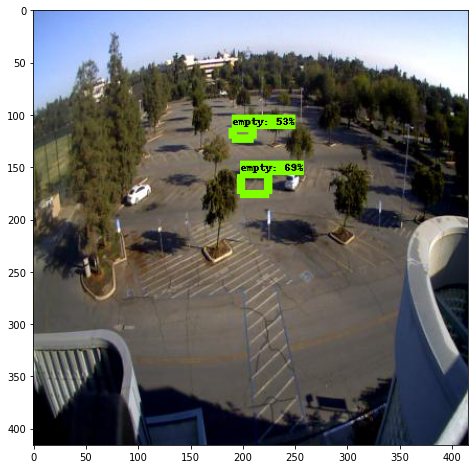

In [37]:
# Limited displayed images to 5 to reduce memory
count = 5
for i, image_path in enumerate(TEST_IMAGE_PATHS):
    if i > count:
        break
    image = Image.open(image_path)
    # the array based representation of the image will be used later in order to prepare the
    # result image with boxes and labels on it.
    image_np = load_image_into_numpy_array(image)
    # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
    image_np_expanded = np.expand_dims(image_np, axis=0)
    # Actual detection.
    output_dict = run_inference_for_single_image(image_np, detection_graph)
    # Visualization of the results of a detection.
    vis_util.visualize_boxes_and_labels_on_image_array(
        image_np,
        output_dict['detection_boxes'],
        output_dict['detection_classes'],
        output_dict['detection_scores'],
        category_index,
        instance_masks=output_dict.get('detection_masks'),
        use_normalized_coordinates=True,
        line_thickness=8)
    plt.figure(figsize=IMAGE_SIZE)
    plt.imshow(image_np)

# 3. Convert

With our model trained, it's time to convert our graph to .tflite!

In [38]:
%ls /content/models/research/fine_tuned_model/tflite

tflite_graph.pb  tflite_graph.pbtxt


In [40]:
!tflite_convert \
  --input_shape=1,300,300,3 \
  --input_arrays=normalized_input_image_tensor \
  --output_arrays=TFLite_Detection_PostProcess,TFLite_Detection_PostProcess:1,TFLite_Detection_PostProcess:2,TFLite_Detection_PostProcess:3 \
  --allow_custom_ops \
  --graph_def_file=/content/models/research/fine_tuned_model/tflite/tflite_graph.pb \
  --output_file="/content/models/research/fine_tuned_model/final_1_model.tflite"

2021-11-08 07:13:08.372139: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2021-11-08 07:13:08.376484: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-08 07:13:08.377055: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Found device 0 with properties: 
name: Tesla P100-PCIE-16GB major: 6 minor: 0 memoryClockRate(GHz): 1.3285
pciBusID: 0000:00:04.0
2021-11-08 07:13:08.377387: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2021-11-08 07:13:08.379069: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2021-11-08 07:13:08.380190: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuf

In [41]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [42]:
# Change the final TFLite destination here
!cp /content/models/research/fine_tuned_model/final_1_model.tflite "/content/drive/My Drive/"

In [43]:
pip install tflite-support-nightly

     |████████████████████████████████| 1.1 MB 4.1 MB/s 
     |████████████████████████████████| 208 kB 70.9 MB/s 


In [44]:
from tflite_support.metadata_writers import object_detector
from tflite_support.metadata_writers import writer_utils

In [49]:
ObjectDetectorWriter = object_detector.MetadataWriter
_MODEL_PATH = "/content/models/research/fine_tuned_model/final_1_model.tflite"
# Task Library expects label files that are in the same format as the one below.
_LABEL_FILE = "/content/drive/MyDrive/Fnl_Parking_App1/labels.txt"
_SAVE_TO_PATH = "/content/models/research/fine_tuned_model/final_1_metadata.tflite"
# Normalization parameters is required when reprocessing the image. It is
# optional if the image pixel values are in range of [0, 255] and the input
# tensor is quantized to uint8. See the introduction for normalization and
# quantization parameters below for more details.
# https://www.tensorflow.org/lite/convert/metadata#normalization_and_quantization_parameters)
_INPUT_NORM_MEAN = 127.5
_INPUT_NORM_STD = 127.5

# Create the metadata writer.
writer = ObjectDetectorWriter.create_for_inference(
    writer_utils.load_file(_MODEL_PATH), [_INPUT_NORM_MEAN], [_INPUT_NORM_STD],
    [_LABEL_FILE])

# Verify the metadata generated by metadata writer.
print(writer.get_metadata_json())

# Populate the metadata into the model.
writer_utils.save_file(writer.populate(), _SAVE_TO_PATH)

{
  "name": "ObjectDetector",
  "description": "Identify which of a known set of objects might be present and provide information about their positions within the given image or a video stream.",
  "subgraph_metadata": [
    {
      "input_tensor_metadata": [
        {
          "name": "image",
          "description": "Input image to be detected.",
          "content": {
            "content_properties_type": "ImageProperties",
            "content_properties": {
              "color_space": "RGB"
            }
          },
          "process_units": [
            {
              "options_type": "NormalizationOptions",
              "options": {
                "mean": [
                  127.5
                ],
                "std": [
                  127.5
                ]
              }
            }
          ],
          "stats": {
            "max": [
              1.0
            ],
            "min": [
              -1.0
            ]
          }
        }
      ],
     

In [53]:
from tflite_support.metadata_writers import object_detector
from tflite_support.metadata_writers import metadata_info
from tflite_support.metadata_writers import writer_utils
from tflite_support import metadata_schema_py_generated as _metadata_fb







<!DOCTYPE html>
<html lang="en" data-color-mode="auto" data-light-theme="light" data-dark-theme="dark">
  <head>
    <meta charset="utf-8">
  <link rel="dns-prefetch" href="https://github.githubassets.com">
  <link rel="dns-prefetch" href="https://avatars.githubusercontent.com">
  <link rel="dns-prefetch" href="https://github-cloud.s3.amazonaws.com">
  <link rel="dns-prefetch" href="https://user-images.githubusercontent.com/">
  <link rel="preconnect" href="https://github.githubassets.com" crossorigin>
  <link rel="preconnect" href="https://avatars.githubusercontent.com">



  <link crossorigin="anonymous" media="all" integrity="sha512-L06pZD/4Yecj8D8pY5aYfA7oKG6CI8/hlx2K9ZlXOS/j5TnYEjrusaVa9ZIb9O3/tBHmnRFLzaC1ixcafWtaAg==" rel="stylesheet" href="https://github.githubassets.com/assets/light-2f4ea9643ff861e723f03f296396987c.css" /><link crossorigin="anonymous" media="all" integrity="sha512-xcx3R1NmKjgOAE2DsCHYbus068pwqr4i3Xaa1osduISrxqYFi3zIaBLqjzt5FM9VSHqFN7mneFXK73Z9a2QRJg==" re
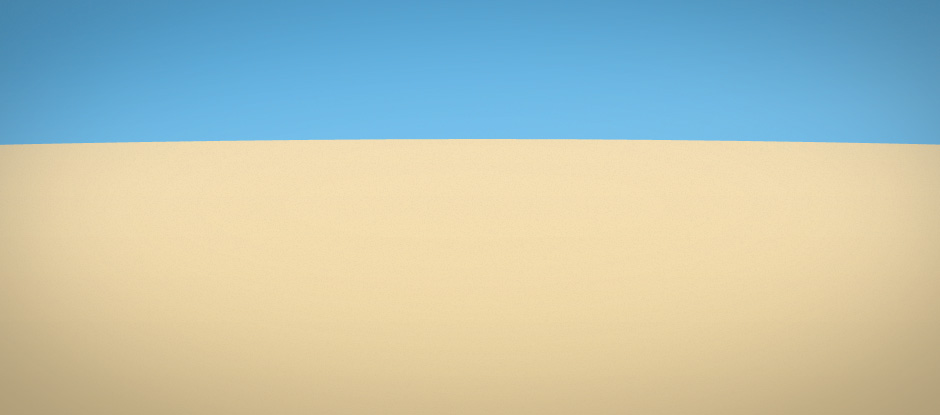
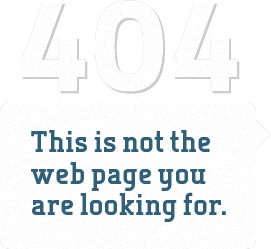
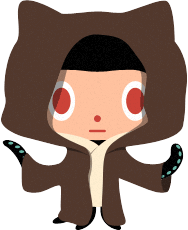
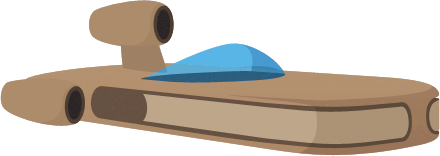
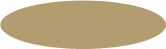
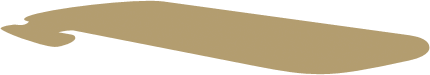
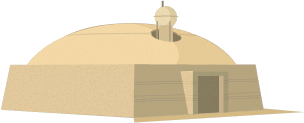
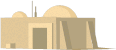
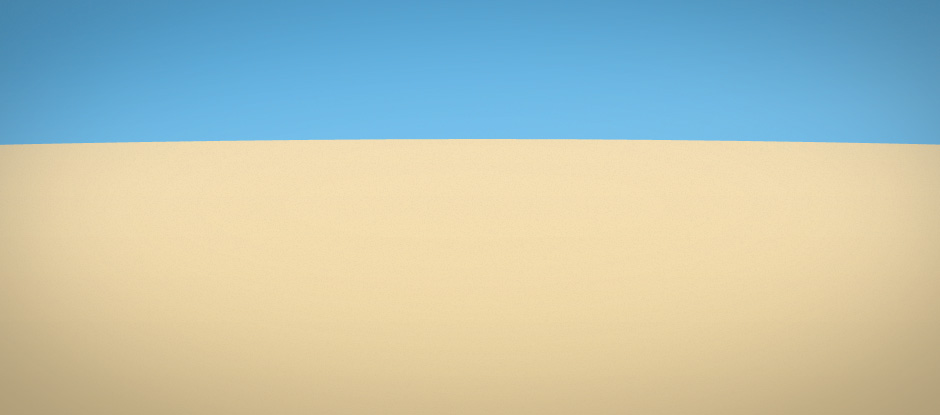
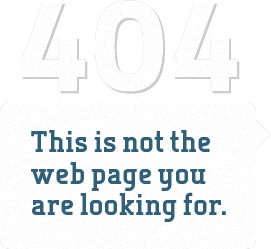
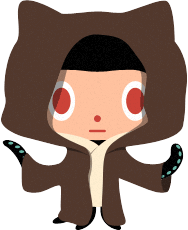
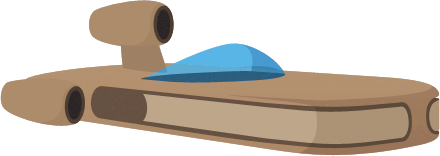
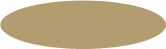
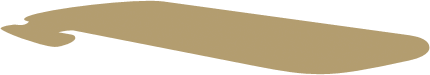
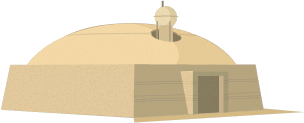
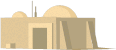

In [59]:
!curl -L "https://github.com/scott2434/fnl_parking_app/blob/main/final_1_model.tflite"
!curl -L "https://github.com/scott2434/fnl_parking_app/blob/main/labels.txt"

In [63]:
model_buffer = writer_utils.load_file("/content/models/research/fine_tuned_model/final_1_model.tflite")

# Create general model information.
general_md = metadata_info.GeneralMd(
    name="ImageClassifier",
    version="v1",
    description=("Identify the most prominent object in the image from a "
                 "known set of categories."),
    author="TensorFlow Lite",
    licenses="Apache License. Version 2.0")

# Create input tensor information.
input_md = metadata_info.InputImageTensorMd(
    name="input image",
    description=("Input image to be classified. The expected image is "
                 "128 x 128, with three channels (red, blue, and green) per "
                 "pixel. Each element in the tensor is a value between min and "
                 "max, where (per-channel) min is [0] and max is [255]."),
    norm_mean=[127.5],
    norm_std=[127.5],
    color_space_type=_metadata_fb.ColorSpaceType.RGB,
    tensor_type=writer_utils.get_input_tensor_types(model_buffer)[0])

# Create output tensor information.
output_md = metadata_info.ClassificationTensorMd(
    name="probability",
    description="Probabilities of the 1001 labels respectively.",
    label_files=[
        metadata_info.LabelFileMd(file_path="/content/drive/MyDrive/Fnl_Parking_App1/labels.txt",
                                  locale="en")
    ],
    tensor_type=writer_utils.get_output_tensor_types(model_buffer)[0])

In [64]:
ObjectDetectorWriter = object_detector.MetadataWriter
# Create the metadata writer.
writer = ObjectDetectorWriter.create_from_metadata_info(
    model_buffer, general_md, input_md, output_md)

# Verify the metadata generated by metadata writer.
print(writer.get_metadata_json())

# Populate the metadata into the model.
writer_utils.save_file(writer.populate(), _SAVE_TO_PATH)

{
  "name": "ImageClassifier",
  "description": "Identify the most prominent object in the image from a known set of categories.",
  "version": "v1",
  "subgraph_metadata": [
    {
      "input_tensor_metadata": [
        {
          "name": "input image",
          "description": "Input image to be classified. The expected image is 128 x 128, with three channels (red, blue, and green) per pixel. Each element in the tensor is a value between min and max, where (per-channel) min is [0] and max is [255].",
          "content": {
            "content_properties_type": "ImageProperties",
            "content_properties": {
              "color_space": "RGB"
            }
          },
          "process_units": [
            {
              "options_type": "NormalizationOptions",
              "options": {
                "mean": [
                  127.5
                ],
                "std": [
                  127.5
                ]
              }
            }
          ],
        

ValueError: ignored

In [52]:
from tflite_support import metadata

displayer = metadata.MetadataDisplayer.with_model_file("/content/models/research/fine_tuned_model/final_1_metadata.tflite")
print("Metadata populated:")
print(displayer.get_metadata_json())

print("Associated file(s) populated:")
for file_name in displayer.get_packed_associated_file_list():
  print("file name: ", file_name)
  print("file content:")
  print(displayer.get_associated_file_buffer(file_name))

Metadata populated:
{
  "name": "ObjectDetector",
  "description": "Identify which of a known set of objects might be present and provide information about their positions within the given image or a video stream.",
  "subgraph_metadata": [
    {
      "input_tensor_metadata": [
        {
          "name": "image",
          "description": "Input image to be detected.",
          "content": {
            "content_properties_type": "ImageProperties",
            "content_properties": {
              "color_space": "RGB"
            }
          },
          "process_units": [
            {
              "options_type": "NormalizationOptions",
              "options": {
                "mean": [
                  127.5
                ],
                "std": [
                  127.5
                ]
              }
            }
          ],
          "stats": {
            "max": [
              1.0
            ],
            "min": [
              -1.0
            ]
          }
    

Your TFLite file is now in your Drive as "final_model.tflite", ready to use with your project on-device! For specific device tutorials, check out the official TensorFlow Lite [Android Demo](https://github.com/tensorflow/examples/tree/master/lite/examples/object_detection/android), [iOS Demo](https://github.com/tensorflow/examples/tree/master/lite/examples/object_detection/ios), or [Raspberry Pi Demo](https://github.com/tensorflow/examples/tree/master/lite/examples/object_detection/raspberry_pi). [link text](https://)